# Lab 2 - Diversity

## Required dependencies

In [ ]:
%pip install jmetalpy
%pip install plotly

In [21]:
import numpy as np 
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

pd.options.plotting.backend = "plotly"

In [22]:
import logging

logger = logging.getLogger('jmetal.core.algorithm')
logger.setLevel(logging.INFO)

## Different types of plots

When working with evolutionary algorithms, it is often necessary to visualize the population of solutions in order to gain insights into the optimization process. There are various types of plots that can be used for this purpose, and in this context, we will explore some of the most useful ones.

Visualizing the population can help us to understand how the algorithm is exploring the search space, how the fitness values are distributed, and how the diversity of the population changes over time. This information can be used to guide the selection of appropriate algorithm parameters, such as mutation rates and selection strategies, and to diagnose potential issues with the optimization process.

Let's start by generating a random population:

In [73]:
np.random.seed(42)
POPULATION_SIZE = 50
NUMBER_OF_DIMENSIONS = 3
population = np.random.rand(POPULATION_SIZE, NUMBER_OF_DIMENSIONS)

In [74]:
population[0]

array([0.37454012, 0.95071431, 0.73199394])

Let's consider an example where we have a population of solutions that can be divided into three groups (A, B, and C). To assign each solution to a group randomly, we can use a `np.random.choice` function:

In [75]:
groups = np.random.choice(["A", "B", "C"], POPULATION_SIZE)

The easiest and most convenient way to generate plots in Python is by using the built-in plotting capabilities of pandas.

In [76]:
population_df = pd.DataFrame(population, columns=["x", "y", "z"])
population_df["group"] = groups

### Scatter plots (2D and 3D)
A scatter plot is a type of plot used to visualize the relationship between two (or three) variables.

In [77]:
fig = population_df.plot(kind="scatter", x="x", y="y", color="group")
fig.update_layout(width=800, height=800)
fig.show()

We can also directly use `plotly`.

In [78]:
fig = px.scatter_3d(population_df, x="x", y="y", z="z", color="group")
fig.show()

### High-dimensional data
- In optimization problems, the goal is to find the best solution to a problem within a given set of constraints. Often, the solution space can be very large and complex, with many variables and constraints that need to be considered. In such cases, the problem can be formulated as a high-dimensional optimization problem, where the number of variables is very large.
- Visualizing highly dimensional data can be challenging, as it is difficult to represent more than three dimensions in a 2D or 3D plot. However, there are several techniques that can be used to visualize high-dimensional data.

In [79]:
POPULATION_SIZE = 15
NUMBER_OF_DIMENSIONS = 10
GROUP_TO_GROUP_IDX = {"A": 0, "B": 1, "C": 2}
dimensions = [f"x_{i}" for i in range(NUMBER_OF_DIMENSIONS)]
high_dimensional_population = np.random.rand(POPULATION_SIZE, NUMBER_OF_DIMENSIONS)
high_dimensional_groups = np.random.choice(["A", "B", "C"], POPULATION_SIZE)
high_dimensional_population_df = pd.DataFrame(
    high_dimensional_population, columns=dimensions
)
high_dimensional_population_df["group"] = high_dimensional_groups
high_dimensional_population_df["group_idx"] = high_dimensional_population_df[
    "group"
].apply(lambda x: GROUP_TO_GROUP_IDX[x])

#### Parallel coordinates
`parallel_coordinates` is a visualization technique that is used to plot high-dimensional data in a 2D space.

Each variable is represented by a vertical axis, and each data point is represented by a line that connects the values of the variables. The lines are parallel to each other, hence the name "parallel coordinates". The values of each variable are normalized to fit within the same range, so that they can be plotted on the same scale.

In [80]:
fig = px.parallel_coordinates(
    high_dimensional_population_df,
    dimensions=dimensions,
    color="group_idx",
)

fig.show()

The `parallel_coordinates` plot can sometimes be difficult to interpret, especially when the number of variables is large. This is because the lines can become tangled and difficult to distinguish from each other, making it hard to see the patterns and relationships between the variables.

#### Selecting 2-3 (random) dimensions

In [81]:
fig = px.scatter_3d(
    high_dimensional_population_df,
    x="x_0",
    y="x_1",
    z="x_2",
    color="group"
)
fig.show()

#### Radar (spider) chart
Spider chart are frequently used to compare different models: https://huggingface.co/HuggingFaceH4/zephyr-7b-beta.

In [83]:
# We plot the mean of each group in a radar chart
means = high_dimensional_population_df.groupby("group").mean()

fig = go.Figure(
    [
        go.Scatterpolar(
            r=means.loc[group][dimensions], theta=means.columns, fill="toself", name=group
        )
        for group in means.index
    ]
)

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True, range=[0, 1])), showlegend=True
)

fig.show()

#### Dimensionality reduction methods
Dimensionality reduction methods are a set of techniques used to reduce the number of variables in a high-dimensional dataset while preserving the most important information. These methods can be used to visualize high-dimensional data in a lower-dimensional space, making it easier to interpret and analyze.

One common dimensionality reduction method is principal component analysis (PCA), which is used to transform the original variables into a new set of variables that capture the most important information in the data. PCA works by finding the directions of maximum variance in the data, and projecting the data onto these directions. The resulting transformed data can be visualized in a lower-dimensional space, such as a 2D or 3D plot.

In [84]:
from sklearn.decomposition import PCA

POPULATION_SIZE = 100
high_dimensional_population = np.random.rand(POPULATION_SIZE, 10)
high_dimensional_groups = np.random.choice(["A", "B", "C"], POPULATION_SIZE)

pca = PCA(n_components=2)
transformed_population = pca.fit_transform(high_dimensional_population)

fig = px.scatter(x=transformed_population[:, 0], y=transformed_population[:, 1], color=high_dimensional_groups) 
fig.update_layout(width=800, height=800)
fig.show()

## Genetic algorithm

We modify the GeneticAlgorithm:
- new field called `populations` - a list of populations from all epochs,
- new method called `_save_current_population`,
- adjusted `evaluate` method.

In [92]:
from typing import TypeVar, List

from jmetal.config import store
from jmetal.core.algorithm import EvolutionaryAlgorithm
from jmetal.core.operator import Mutation, Crossover, Selection
from jmetal.core.problem import Problem
from jmetal.util.evaluator import Evaluator
from jmetal.util.generator import Generator
from jmetal.util.termination_criterion import TerminationCriterion

S = TypeVar('S')
R = TypeVar('R')

"""
.. module:: genetic_algorithm
   :platform: Unix, Windows
   :synopsis: Implementation of Genetic Algorithms.
.. moduleauthor:: Antonio J. Nebro <antonio@lcc.uma.es>, Antonio Benítez-Hidalgo <antonio.b@uma.es>
"""


class CustomGeneticAlgorithm(EvolutionaryAlgorithm[S, R]):

    def __init__(self,
                 problem: Problem,
                 population_size: int,
                 offspring_population_size: int,
                 mutation: Mutation,
                 crossover: Crossover,
                 selection: Selection,
                 termination_criterion: TerminationCriterion = store.default_termination_criteria,
                 population_generator: Generator = store.default_generator,
                 population_evaluator: Evaluator = store.default_evaluator):
        super(CustomGeneticAlgorithm, self).__init__(
            problem=problem,
            population_size=population_size,
            offspring_population_size=offspring_population_size)
        self.mutation_operator = mutation
        self.crossover_operator = crossover
        self.selection_operator = selection

        self.population_generator = population_generator
        self.population_evaluator = population_evaluator

        self.termination_criterion = termination_criterion
        self.observable.register(termination_criterion)

        self.mating_pool_size = \
            self.offspring_population_size * \
            self.crossover_operator.get_number_of_parents() // self.crossover_operator.get_number_of_children()

        if self.mating_pool_size < self.crossover_operator.get_number_of_children():
            self.mating_pool_size = self.crossover_operator.get_number_of_children()
        
        # Custom field:
        self._populations = []

    def create_initial_solutions(self) -> List[S]:
        return [self.population_generator.new(self.problem)
                for _ in range(self.population_size)]

    def evaluate(self, population: List[S]):
        ret = self.population_evaluator.evaluate(population, self.problem)
        return ret
    
    @property
    def populations(self) -> np.ndarray:
        return np.asarray(self._populations)

    # Custom method:
    def _save_current_population(self, population: List[S]) -> None:
      self._populations.append([individual.variables for individual in population])

    def stopping_condition_is_met(self) -> bool:
        return self.termination_criterion.is_met

    def selection(self, population: List[S]):
        mating_population = []

        for i in range(self.mating_pool_size):
            solution = self.selection_operator.execute(population)
            mating_population.append(solution)

        return mating_population

    def reproduction(self, mating_population: List[S]) -> List[S]:
        number_of_parents_to_combine = self.crossover_operator.get_number_of_parents()

        if len(mating_population) % number_of_parents_to_combine != 0:
            raise Exception('Wrong number of parents')

        offspring_population = []
        for i in range(0, self.offspring_population_size, number_of_parents_to_combine):
            parents = []
            for j in range(number_of_parents_to_combine):
                parents.append(mating_population[i + j])

            offspring = self.crossover_operator.execute(parents)

            for solution in offspring:
                self.mutation_operator.execute(solution)
                offspring_population.append(solution)
                if len(offspring_population) >= self.offspring_population_size:
                    break

        return offspring_population

    def replacement(self, population: List[S], offspring_population: List[S]) -> List[S]:
        population.extend(offspring_population)

        population.sort(key=lambda s: s.objectives[0])

        new_population = population[:self.population_size]
        # Custom code:
        self._save_current_population(new_population)

        return new_population

    def result(self) -> R:
        return self.solutions[0]

    def get_name(self) -> str:
        return 'Genetic algorithm 1'

### Rastrigin function

The Rastrigin function is a commonly used test function in optimization and machine learning. It is a non-convex function that is often used to test the performance of optimization algorithms, as it has many local minima and is difficult to optimize.

The Rastrigin function is defined as:

$$ f(x) = 10d + \sum_{i=1}^d[x_i^2 - 10\cos{(2 \pi x_i)}] $$

The function is usually evaluated on the hypercube $ x_i \in [-5.12, 5.12]$, for all $i = 1, …, d$.

Global Minimum:

$f(x^*) = 0$, at $x^* = (0, … 0)$.


![rastrigin](https://www.sfu.ca/~ssurjano/rastr.png)

In [115]:
def rastrigin(x, y):
    return 20 + x**2 - 10 * np.cos(2 * np.pi * x) + y**2 - 10 * np.cos(2 * np.pi * y)

Rastrigin for $d=2$:

In [93]:
from jmetal.problem.singleobjective.unconstrained import Rastrigin

d = 2
problem = Rastrigin(d)

In [122]:
from jmetal.algorithm.singleobjective.genetic_algorithm import GeneticAlgorithm
from jmetal.operator import BinaryTournamentSelection, PolynomialMutation, SBXCrossover
from jmetal.util.termination_criterion import StoppingByEvaluations

# Let us run the algorithm with artificial parameters:
POPULATION_SIZE = 4
OFFSPRING_POPULATION_SIZE = 4
MUTATION = PolynomialMutation(1.0 / problem.number_of_variables(), 20.0)
CROSSOVER = SBXCrossover(0.9, 20.0)
SELECTION = BinaryTournamentSelection()
MAX_EVALUATIONS = 100

algorithm = CustomGeneticAlgorithm(
  problem=problem,
  population_size=POPULATION_SIZE,
  offspring_population_size=OFFSPRING_POPULATION_SIZE,
  mutation=MUTATION,
  crossover=CROSSOVER,
  selection=SELECTION,
  termination_criterion=StoppingByEvaluations(max_evaluations=MAX_EVALUATIONS))


algorithm.run()

result = algorithm.result()

print('Algorithm: {}'.format(algorithm.get_name()))
print('Problem: {}'.format(problem.name()))
print('Solution: {}'.format(result.variables))
print('Fitness: {}'.format(result.objectives[0]))
print('Computing time: {}'.format(algorithm.total_computing_time))

[2024-10-20 15:43:38,447] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2024-10-20 15:43:38,448] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2024-10-20 15:43:38,449] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2024-10-20 15:43:38,449] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2024-10-20 15:43:38,452] [jmetal.core.algorithm] [DEBUG] Finished!


Algorithm: Genetic algorithm 1
Problem: Rastrigin
Solution: [-0.007239968009658648, 0.9864964509639854]
Fitness: 1.0195446471069687
Computing time: 0.00568389892578125


#### Heat map, contour plot

Let's plot the first population:

In [140]:
NUMBER_OF_CONTOURS = 20
NUMBER_OF_POINTS = 100

first_population = algorithm.populations[0]

# Generate meshgrid for contour plot
x = np.linspace(problem.lower_bound[0], problem.upper_bound[0], NUMBER_OF_POINTS)
y = np.linspace(problem.lower_bound[1], problem.upper_bound[1], NUMBER_OF_POINTS)
X, Y = np.meshgrid(x, y)
Z = rastrigin(X, Y)

fig = go.Figure(
    data=[
        go.Contour(
            z=Z,
            x=x,
            y=y,
            colorscale="Viridis",
            contours=dict(
                start=np.min(Z),
                end=np.max(Z),
                size=(np.max(Z) - np.min(Z)) / NUMBER_OF_CONTOURS,
            ),
            colorbar=dict(title="Rastrigin function value"),
        )
    ]
)

fig.add_trace(
    go.Scatter(
        x=first_population[:, 0],
        y=first_population[:, 1],
        mode="markers",
        marker=dict(color="red"),
        name="First Population",
    )
)

fig.update_layout(
    title="Contour plot of the Rastrigin function and the first population",
    showlegend=False,
    width=800,
    height=800,
)

# Show the plot
fig.show()

GIFs are a great way to visualize population changes over time, making trends easy to observe at a glance.

In [139]:
fig = go.Figure()

contour_trace = go.Contour(
    z=Z,
    x=x,
    y=y,
    colorscale="Viridis",
    contours=dict(
        start=np.min(Z),
        end=np.max(Z),
        size=(np.max(Z) - np.min(Z)) / NUMBER_OF_CONTOURS,
    ),
    colorbar=dict(title="Rastrigin function value"),
)

fig.add_trace(contour_trace)

initial_population = algorithm.populations[0]
scatter_trace = go.Scatter(
    x=initial_population[:, 0],
    y=initial_population[:, 1],
    mode="markers",
    marker=dict(color="red"),
    name="First Population",
)

fig.add_trace(scatter_trace)

frames = [
    go.Frame(
        data=[
            go.Contour(z=Z, x=x, y=y, colorscale="Viridis", showscale=False),
            go.Scatter(
                x=population[:, 0],
                y=population[:, 1],
                mode="markers",
                marker=dict(color="red"),
            ),
        ],
        name=f"Population {i}",
    )
    for i, population in enumerate(algorithm.populations)
]

fig.frames = frames

fig.update_layout(
    title="Contour plot of the Rastrigin function with evolving populations",
    width=800,
    height=800,
    xaxis=dict(range=[problem.lower_bound[0], problem.upper_bound[0]]),
    yaxis=dict(range=[problem.lower_bound[1], problem.upper_bound[1]]),
    showlegend=False,
)

fig.update_layout(
    sliders=[
        {
            "steps": [
                {
                    "args": [
                        [f"Population {i}"],
                        {
                            "frame": {"duration": 1, "redraw": True},
                            "mode": "immediate",
                        },
                    ],
                    "label": f"Population {i}",
                    "method": "animate",
                }
                for i in range(len(algorithm.populations))
            ],
            "active": 0,
            "yanchor": "top",
            "xanchor": "left",
            "currentvalue": {
                "prefix": "Population: ",
                "font": {"size": 20},
                "visible": True,
            },
        }
    ]
)
fig.show()

MovieWriter imagemagick unavailable; using Pillow instead.


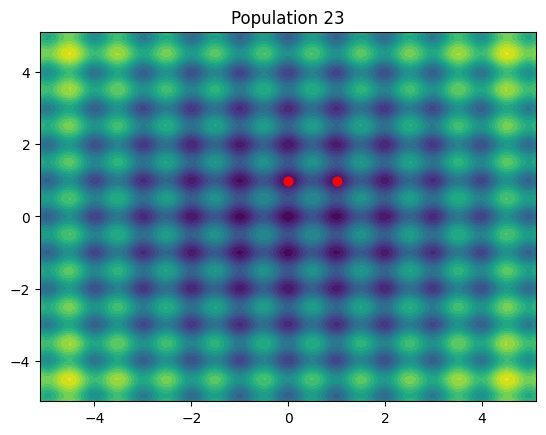

In [132]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.contourf(X, Y, Z, 20, cmap="viridis")
scatter = ax.scatter(x=first_population[:, 0], y=first_population[:, 1], color="red")
ax.set_title(f"Population {0}")
scatters = [scatter]


def update(num):
    ax.clear()
    ax.set_title(f"Population {num}")
    ax.contourf(X, Y, Z, 20, cmap="viridis")
    scatter = ax.scatter(
        algorithm.populations[num][:, 0], algorithm.populations[num][:, 1], color="red"
    )
    return scatters + [scatter]


ani = FuncAnimation(fig, update, frames=len(algorithm.populations), blit=True)

ani.save("animation.gif", writer="imagemagick")

Exercise 1.

Investigate how number of evaluations and number of individuals affect solution. For every pair (`MAX_EVALUATIONS`, `POPULATION_SIZE`) measure time of execution and get the best fitness value. What are the best parameters regarding time and quality of solution? Create a GIF for this pair of parameters.

Try to use: 

`MAX_EVALUATIONS = [100, 200, 500, 1000, 2000, 5000]`

`POPULATION_SIZE = [10, 20, 50, 100]`

For `POPULATION_SIZE=100` plot best fitness (and time of execution) values by `MAX_EVALUATIONS`.

Q1: "We aim to achieve the best solution in the shortest possible time." How would you describe this optimization problem? <br>
Q2: What's the difference between `POPULATION_SIZE` and `OFFSPRING_POPULATION_SIZE`? Try to adjust (increase) `OFFSPRING_POPULATION_SIZE`. <br>
Q3: How can we improve the way we search/tune parameters?

Exercise 2. 

Execute the Genetic Algorithm on a 10-dimensional Rastrigin function. Generate a scatter plot for the first two dimensions of the last population (use `POPULATION_SIZE=100` and `MAX_EVALUATIONS=1000`). Then, apply Principal Component Analysis (PCA) to the last population and create a scatter plot of the transformed data. Compare the two scatter plots to analyze the differences.

Exercise 3.

Explore the impact of mutation on the solution. Increase/decrease mutation probability/rate. Create GIFs for smallest and largest mutation probability. What are the differences between them? Run algorithm for one of suggested $p_m$ values in the [article](https://www.sciencedirect.com/science/article/pii/089571779500035Z) (end of page 3). Compare results.

Exercise 4.

Develop a metric to measure the diversity of the populations from Exercise 3. Use this metric to assess the quality of the optimization process.

Steps:
1.	Define a Diversity Metric: Create a formula or metric that quantitatively evaluates the diversity within a population (e.g., based on distance between individuals, spread of values, etc.).
2.	Apply the Metric: Use the metric you developed to evaluate the diversity of the populations during the optimization process.
3.	Visualization:
- Generate a plot that shows how the diversity metric changes throughout the optimization (depending on the number of evaluations/iterations).
- Run the algorithm multiple times to observe variations in diversity over different runs.
- Use box and whisker plots to visualize the dispersion of the diversity metric across multiple runs, providing a clear picture of how consistent the diversity is across trials.

Exercise 5.

Multi-start is a technique used in optimization to improve the chances of finding the global minimum of a function. The idea behind multi-start is to run a local optimization algorithm multiple times, each time starting from a different initial point in the search space. By doing this, we increase the chances of finding the global minimum, as each run of the local optimization algorithm may converge to a different local minimum.

The multi-start method works as follows:

1. Select a random starting point (e.g. with uniform distribution over domain).
2. For selected starting point, run the local optimization algorithm until convergence.
3. Record the best solution found across all runs of the local optimization algorithm.
4. Repeat 1-3 `N` times.

Implement multi start method. Use [L-BGS-B](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html) as a local method. Measure the number of fitness function evaluations, compare results with genetic algorithm.

